In [1]:
from genetic_program import FitnessFunction
from gp_artemis import ExperimentManager
%matplotlib inline
import pandas as pd

class WowFitnessFunction(FitnessFunction):
    _name = "ff_sowow"

    def compute(self, individual, evaluation, genetic_program):
        return evaluation.profit_percent * evaluation.num_sells,

class BenchmarkDiffFitnessFunction(FitnessFunction):
    _name = "ff_benchmarkdiff"

    def compute(self, individual, evaluation, genetic_program):
        return evaluation.profit_percent - evaluation.benchmark_backtest.profit_percent,
    
    
    
experiment_json = {
    "training_data": {
        "transaction_currency": "OMG",
        "counter_currency": "BTC",
        "start_time": "2018/04/01 00:00:00 UTC",
        "end_time": "2018/06/01 00:00:00 UTC",
        "resample_period": 60,
        "source": 0
    },

    "validation_data": {
        "transaction_currency": "OMG",
        "counter_currency": "BTC",
        "start_time": "2018/03/01 00:00:00 UTC",
        "end_time": "2018/03/31 00:00:00 UTC",
        "resample_period": 60,
        "source": 0
    },

    "fitness_function": "ff_benchmarkdiff",
    "grammar_version": "gv1",
    "num_generations": 3,

    "mating_probabilities": [
        0.4,
        0.5,
        0.6
    ],

    "mutation_probabilities": [
        0.7,
        0.8,
        0.9
    ],

    "population_sizes": [
        500
    ]
}

e = ExperimentManager(experiment_json, read_from_file=False)
e.run_experiments(display_results=False)


INFO:root:Running variant 0
INFO:artemis:========== Running Experiment: run_evolution.data_OMG-BTC-1522540800.0-1527811200.0;provider_TAprovider;grammar_gv1;fitness_ff_benchmarkdiff;matingprob_0.4;mutationprob_0.7;populationsize_500;generations_3 ==========


   	      	                        fitness                        	             size             
   	      	-------------------------------------------------------	------------------------------
gen	nevals	avg     	max     	min     	std    	avg   	max	min	std   
0  	500   	-13.2368	-7.76193	-36.9333	3.96077	31.782	168	4  	40.463
1  	393   	-11.3099	-8.50299	-36.9333	2.62144	30.052	158	4  	36.7333
2  	417   	-10.3575	-8.50299	-38.8715	2.93221	28.99 	157	4  	35.4667


INFO:artemis:Saving Result for Experiment "2018.08.30T14.53.58.663988-run_evolution.data_OMG-BTC-1522540800.0-1527811200.0;provider_TAprovider;grammar_gv1;fitness_ff_benchmarkdiff;matingprob_0.4;mutationprob_0.7;populationsize_500;generations_3"


3  	402   	-9.9236 	-8.50299	-20.0054	1.4881 	29.562	157	4  	36.2064


INFO:artemis:========== Done Running Experiment: run_evolution.data_OMG-BTC-1522540800.0-1527811200.0;provider_TAprovider;grammar_gv1;fitness_ff_benchmarkdiff;matingprob_0.4;mutationprob_0.7;populationsize_500;generations_3 ==========
INFO:root:Running variant 1
INFO:artemis:========== Running Experiment: run_evolution.data_OMG-BTC-1522540800.0-1527811200.0;provider_TAprovider;grammar_gv1;fitness_ff_benchmarkdiff;matingprob_0.4;mutationprob_0.8;populationsize_500;generations_3 ==========


   	      	                        fitness                        	              size             
   	      	-------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std    	avg   	max	min	std    
0  	500   	-13.3129	-5.09452	-38.8715	4.39504	38.442	169	4  	48.3486
1  	433   	-11.3026	-9.47908	-27.3918	2.45278	38.87 	169	4  	48.2884
2  	446   	-10.2232	-9.47908	-36.9333	2.26636	40.118	167	4  	45.9045


INFO:artemis:Saving Result for Experiment "2018.08.30T14.57.28.400444-run_evolution.data_OMG-BTC-1522540800.0-1527811200.0;provider_TAprovider;grammar_gv1;fitness_ff_benchmarkdiff;matingprob_0.4;mutationprob_0.8;populationsize_500;generations_3"


3  	434   	-9.94834	-9.47908	-36.9333	2.40181	41.47 	159	4  	44.6085


INFO:artemis:========== Done Running Experiment: run_evolution.data_OMG-BTC-1522540800.0-1527811200.0;provider_TAprovider;grammar_gv1;fitness_ff_benchmarkdiff;matingprob_0.4;mutationprob_0.8;populationsize_500;generations_3 ==========
INFO:root:Running variant 2
INFO:artemis:========== Running Experiment: run_evolution.data_OMG-BTC-1522540800.0-1527811200.0;provider_TAprovider;grammar_gv1;fitness_ff_benchmarkdiff;matingprob_0.4;mutationprob_0.9;populationsize_500;generations_3 ==========


   	      	                        fitness                        	              size             
   	      	-------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std    	avg   	max	min	std    
0  	500   	-13.3582	-3.39149	-36.9333	4.40149	37.024	168	4  	46.0991
1  	459   	-11.3772	-6.0484 	-20.2139	2.34367	33.942	168	4  	43.5993
2  	465   	-10.2981	-6.0484 	-15.195 	1.78835	34.922	168	4  	43.5096


INFO:artemis:Saving Result for Experiment "2018.08.30T15.01.51.155191-run_evolution.data_OMG-BTC-1522540800.0-1527811200.0;provider_TAprovider;grammar_gv1;fitness_ff_benchmarkdiff;matingprob_0.4;mutationprob_0.9;populationsize_500;generations_3"


3  	461   	-10.0878	-6.0484 	-36.9333	2.55486	38.85 	168	4  	44.9647


INFO:artemis:========== Done Running Experiment: run_evolution.data_OMG-BTC-1522540800.0-1527811200.0;provider_TAprovider;grammar_gv1;fitness_ff_benchmarkdiff;matingprob_0.4;mutationprob_0.9;populationsize_500;generations_3 ==========
INFO:root:Running variant 3
INFO:artemis:========== Running Experiment: run_evolution.data_OMG-BTC-1522540800.0-1527811200.0;provider_TAprovider;grammar_gv1;fitness_ff_benchmarkdiff;matingprob_0.5;mutationprob_0.7;populationsize_500;generations_3 ==========


   	      	                    fitness                    	              size             
   	      	-----------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min    	std    	avg   	max	min	std    
0  	500   	-13.2616	-3.72309	-37.288	4.19414	36.998	176	4  	45.8667
1  	437   	-11.2284	-4.35698	-36.9333	2.68747	38.018	166	4  	42.6466
2  	432   	-10.2492	-1.0075 	-37.288 	2.35738	36.206	166	4  	38.9497


INFO:artemis:Saving Result for Experiment "2018.08.30T15.05.51.321342-run_evolution.data_OMG-BTC-1522540800.0-1527811200.0;provider_TAprovider;grammar_gv1;fitness_ff_benchmarkdiff;matingprob_0.5;mutationprob_0.7;populationsize_500;generations_3"


3  	419   	-9.71255	-1.0075 	-26.2596	1.94617	37.61 	166	4  	36.6349


INFO:artemis:========== Done Running Experiment: run_evolution.data_OMG-BTC-1522540800.0-1527811200.0;provider_TAprovider;grammar_gv1;fitness_ff_benchmarkdiff;matingprob_0.5;mutationprob_0.7;populationsize_500;generations_3 ==========
INFO:root:Running variant 4
INFO:artemis:========== Running Experiment: run_evolution.data_OMG-BTC-1522540800.0-1527811200.0;provider_TAprovider;grammar_gv1;fitness_ff_benchmarkdiff;matingprob_0.5;mutationprob_0.8;populationsize_500;generations_3 ==========


   	      	                        fitness                        	              size             
   	      	-------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std    	avg   	max	min	std    
0  	500   	-13.5331	-9.47908	-38.8715	4.75529	36.204	173	4  	46.6479
1  	446   	-11.523 	-3.66114	-36.9333	3.09411	33.87 	173	4  	43.5131
2  	452   	-10.2151	-3.66114	-36.9333	2.05735	34.184	162	4  	41.5801


INFO:artemis:Saving Result for Experiment "2018.08.30T15.09.45.082219-run_evolution.data_OMG-BTC-1522540800.0-1527811200.0;provider_TAprovider;grammar_gv1;fitness_ff_benchmarkdiff;matingprob_0.5;mutationprob_0.8;populationsize_500;generations_3"


3  	455   	-9.99591	-3.66114	-36.9333	2.26065	35.016	162	4  	39.8819


INFO:artemis:========== Done Running Experiment: run_evolution.data_OMG-BTC-1522540800.0-1527811200.0;provider_TAprovider;grammar_gv1;fitness_ff_benchmarkdiff;matingprob_0.5;mutationprob_0.8;populationsize_500;generations_3 ==========
INFO:root:Running variant 5
INFO:artemis:========== Running Experiment: run_evolution.data_OMG-BTC-1522540800.0-1527811200.0;provider_TAprovider;grammar_gv1;fitness_ff_benchmarkdiff;matingprob_0.5;mutationprob_0.9;populationsize_500;generations_3 ==========


   	      	                        fitness                        	              size             
   	      	-------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std    	avg  	max	min	std    
0  	500   	-12.9993	-9.47908	-36.9333	3.53153	33.32	170	4  	43.7161
1  	476   	-11.3578	-9.47908	-26.2407	2.38313	33.31	165	4  	42.8212
2  	474   	-10.2497	-9.47908	-27.0681	2.04539	31.688	165	4  	40.3731


INFO:artemis:Saving Result for Experiment "2018.08.30T15.13.35.489983-run_evolution.data_OMG-BTC-1522540800.0-1527811200.0;provider_TAprovider;grammar_gv1;fitness_ff_benchmarkdiff;matingprob_0.5;mutationprob_0.9;populationsize_500;generations_3"


3  	476   	-9.92765	-9.47908	-14.2616	1.38617	31.918	165	4  	37.0809


INFO:artemis:========== Done Running Experiment: run_evolution.data_OMG-BTC-1522540800.0-1527811200.0;provider_TAprovider;grammar_gv1;fitness_ff_benchmarkdiff;matingprob_0.5;mutationprob_0.9;populationsize_500;generations_3 ==========
INFO:root:Running variant 6
INFO:artemis:========== Running Experiment: run_evolution.data_OMG-BTC-1522540800.0-1527811200.0;provider_TAprovider;grammar_gv1;fitness_ff_benchmarkdiff;matingprob_0.6;mutationprob_0.7;populationsize_500;generations_3 ==========


   	      	                        fitness                        	              size             
   	      	-------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std    	avg   	max	min	std    
0  	500   	-13.0988	-9.47908	-36.9333	4.12254	35.364	174	4  	46.1951
1  	440   	-11.1943	-9.47908	-15.195 	2.27113	31.336	174	4  	39.9883
2  	460   	-10.4163	-9.47908	-15.195 	1.8893 	30.264	171	4  	37.7199


INFO:artemis:Saving Result for Experiment "2018.08.30T15.17.31.633246-run_evolution.data_OMG-BTC-1522540800.0-1527811200.0;provider_TAprovider;grammar_gv1;fitness_ff_benchmarkdiff;matingprob_0.6;mutationprob_0.7;populationsize_500;generations_3"


3  	442   	-9.97734	-9.47908	-15.195 	1.45696	35.21 	159	4  	41.2023


INFO:artemis:========== Done Running Experiment: run_evolution.data_OMG-BTC-1522540800.0-1527811200.0;provider_TAprovider;grammar_gv1;fitness_ff_benchmarkdiff;matingprob_0.6;mutationprob_0.7;populationsize_500;generations_3 ==========
INFO:root:Running variant 7
INFO:artemis:========== Running Experiment: run_evolution.data_OMG-BTC-1522540800.0-1527811200.0;provider_TAprovider;grammar_gv1;fitness_ff_benchmarkdiff;matingprob_0.6;mutationprob_0.8;populationsize_500;generations_3 ==========


   	      	                        fitness                        	              size             
   	      	-------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std    	avg   	max	min	std    
0  	500   	-13.3401	-3.32332	-36.9333	4.80732	38.938	170	4  	47.8856
1  	455   	-11.3673	-3.32332	-36.9333	3.10918	33.552	170	4  	41.4079
2  	468   	-10.3989	-3.32332	-37.288 	2.77758	33.444	161	4  	38.1205


INFO:artemis:Saving Result for Experiment "2018.08.30T15.20.52.106117-run_evolution.data_OMG-BTC-1522540800.0-1527811200.0;provider_TAprovider;grammar_gv1;fitness_ff_benchmarkdiff;matingprob_0.6;mutationprob_0.8;populationsize_500;generations_3"


3  	464   	-10.0287	-1.0075 	-36.9333	2.66103	34.602	161	4  	35.7017


INFO:artemis:========== Done Running Experiment: run_evolution.data_OMG-BTC-1522540800.0-1527811200.0;provider_TAprovider;grammar_gv1;fitness_ff_benchmarkdiff;matingprob_0.6;mutationprob_0.8;populationsize_500;generations_3 ==========
INFO:root:Running variant 8
INFO:artemis:========== Running Experiment: run_evolution.data_OMG-BTC-1522540800.0-1527811200.0;provider_TAprovider;grammar_gv1;fitness_ff_benchmarkdiff;matingprob_0.6;mutationprob_0.9;populationsize_500;generations_3 ==========


   	      	                    fitness                    	              size             
   	      	-----------------------------------------------	-------------------------------
gen	nevals	avg     	max    	min     	std    	avg   	max	min	std    
0  	500   	-13.4056	-6.0484	-36.9333	4.75407	35.458	168	4  	43.3332
1  	482   	-11.5057	-6.0484	-36.9333	3.37738	31.408	162	4  	38.2539
2  	479   	-10.2183	-6.0484	-36.9333	2.1577 	31.786	162	4  	34.9872


INFO:artemis:Saving Result for Experiment "2018.08.30T15.24.25.900836-run_evolution.data_OMG-BTC-1522540800.0-1527811200.0;provider_TAprovider;grammar_gv1;fitness_ff_benchmarkdiff;matingprob_0.6;mutationprob_0.9;populationsize_500;generations_3"


3  	481   	-9.89991	-6.0484	-36.9333	2.41541	36.534	162	4  	36.7446


INFO:artemis:========== Done Running Experiment: run_evolution.data_OMG-BTC-1522540800.0-1527811200.0;provider_TAprovider;grammar_gv1;fitness_ff_benchmarkdiff;matingprob_0.6;mutationprob_0.9;populationsize_500;generations_3 ==========


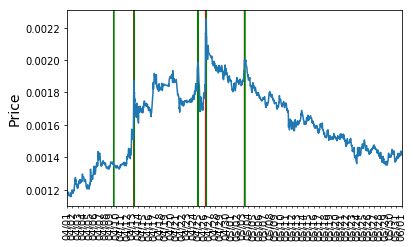

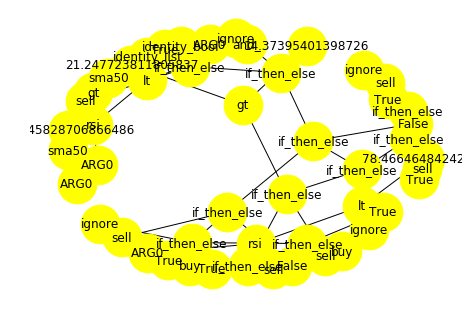

In [2]:
performance_df = e.analyze_and_find_best()

In [3]:
import pandas as pd
pd.set_option('display.max_columns', 500)
performance_df

,abc_negative_cache_version,alpha,benchmark_profit_percent,benchmark_profit_percent_usdt,beta,buy_currency,cash,counter_currency,crypto,current_price,current_timestamp,end_cash,end_crypto,end_crypto_currency,end_price,end_time,end_value,end_value_usdt,evaluate_profit_on_last_order,evaluation,experiment_id,hof_ranking,individual,max_buy_sell_pair_gain,max_buy_sell_pair_loss,max_buy_sell_pair_return,max_drawdown,max_drawdown_duration,mean_buy_sell_pair_gain,mean_buy_sell_pair_loss,mean_buy_sell_pair_return,min_buy_sell_pair_gain,min_buy_sell_pair_loss,min_buy_sell_pair_return,num_buy_sell_pairs,num_buys,num_gains,num_losses,num_orders,num_profitable_trades,num_sells,num_trades,num_unprofitable_trades,percent_profitable_trades,profit,profit_percent,profit_percent_usdt,profit_usdt,resample_period,sharpe_ratio,slippage,source,start_cash,start_crypto,start_time,start_value,start_value_usdt,std_buy_sell_pair_gain,std_buy_sell_pair_loss,std_buy_sell_pair_return,time_delay,transaction_cost_percent,transaction_currency,verbose
70,51,0.001350,14.261649,19.364172,0.870541,OMG,0.0,BTC,800507.153796,0.001415,1.527811e+09,0.0,800507.153796,OMG,0.001415,1.527811e+09,1132.541511,8.470302e+06,True,<backtester_ticks.TickDrivenBacktester object ...,run_evolution.data_OMG-BTC-1522540800.0-152781...,0,"[<deap.gp.Primitive object at 0x123440458>, <d...",0.357875,-0.076098,0.357875,-0.372555,2847060.0,0.154426,-0.076098,0.108321,0.042410,-0.076098,-0.076098,5,6,4,1,11,4,5,11,1,0.800000,132.541511,13.254151,22.403215,1.550302e+06,60,0.210297,0,0,1000,0,1.522541e+09,1000,6920000.0,0.120566,0.000000,0.141885,0,0.0025,OMG,False
34,51,0.001350,14.261649,19.364172,0.870541,OMG,0.0,BTC,800507.153796,0.001415,1.527811e+09,0.0,800507.153796,OMG,0.001415,1.527811e+09,1132.541511,8.470302e+06,True,<backtester_ticks.TickDrivenBacktester object ...,run_evolution.data_OMG-BTC-1522540800.0-152781...,4,"[<deap.gp.Primitive object at 0x10d357638>, <d...",0.357875,-0.076098,0.357875,-0.372555,2847060.0,0.154426,-0.076098,0.108321,0.042410,-0.076098,-0.076098,5,6,4,1,11,4,5,11,1,0.800000,132.541511,13.254151,22.403215,1.550302e+06,60,0.210297,0,0,1000,0,1.522541e+09,1000,6920000.0,0.120566,0.000000,0.141885,0,0.0025,OMG,False
33,51,0.001350,14.261649,19.364172,0.870541,OMG,0.0,BTC,800507.153796,0.001415,1.527811e+09,0.0,800507.153796,OMG,0.001415,1.527811e+09,1132.541511,8.470302e+06,True,<backtester_ticks.TickDrivenBacktester object ...,run_evolution.data_OMG-BTC-1522540800.0-152781...,3,"[<deap.gp.Primitive object at 0x10d357638>, <d...",0.357875,-0.076098,0.357875,-0.372555,2847060.0,0.154426,-0.076098,0.108321,0.042410,-0.076098,-0.076098,5,6,4,1,11,4,5,11,1,0.800000,132.541511,13.254151,22.403215,1.550302e+06,60,0.210297,0,0,1000,0,1.522541e+09,1000,6920000.0,0.120566,0.000000,0.141885,0,0.0025,OMG,False
32,51,0.001350,14.261649,19.364172,0.870541,OMG,0.0,BTC,800507.153796,0.001415,1.527811e+09,0.0,800507.153796,OMG,0.001415,1.527811e+09,1132.541511,8.470302e+06,True,<backtester_ticks.TickDrivenBacktester object ...,run_evolution.data_OMG-BTC-1522540800.0-152781...,2,"[<deap.gp.Primitive object at 0x10d357638>, <d...",0.357875,-0.076098,0.357875,-0.372555,2847060.0,0.154426,-0.076098,0.108321,0.042410,-0.076098,-0.076098,5,6,4,1,11,4,5,11,1,0.800000,132.541511,13.254151,22.403215,1.550302e+06,60,0.210297,0,0,1000,0,1.522541e+09,1000,6920000.0,0.120566,0.000000,0.141885,0,0.0025,OMG,False
31,51,0.001350,14.261649,19.364172,0.870541,OMG,0.0,BTC,800507.153796,0.001415,1.527811e+09,0.0,800507.153796,OMG,0.001415,1.527811e+09,1132.541511,8.470302e+06,True,<backtester_ticks.TickDrivenBacktester object ...,run_evolution.data_OMG-BTC-1522540800.0-152781...,1,"[<deap.gp.Primitive object at 0x10d357638>, <d...",0.357875,-0.076098,0.357875,-0.372555,2847060.0,0.154426,-0.076098,0.108321,0.042410,-0.076098,-0.076098,5,6,4,1,11,4,5,11,1,0.800000,132.541511,13.254151,22.403215,1.550302e+06,60,0.210297,0,0,1000,0,1.522541e+09,1000,6920000.0,0.120566,0.000000,0.141885,0,0.0025,OM

In [6]:
best = performance_df.iloc[0]['individual']

In [7]:
str(best)

'if_then_else(and_(lt(rsi(ARG0), sma50(identity_list(ARG0))), identity_bool(gt(sma50(ARG0), 3.1545828706866486))), if_then_else(True, ignore, sell), if_then_else(False, if_then_else(False, sell, if_then_else(True, if_then_else(True, ignore, sell), ignore)), if_then_else(lt(78.46646484242042, rsi(ARG0)), if_then_else(True, sell, if_then_else(True, sell, ignore)), if_then_else(gt(21.247723811805837, 14.37395401398726), if_then_else(True, buy, buy), sell))))'

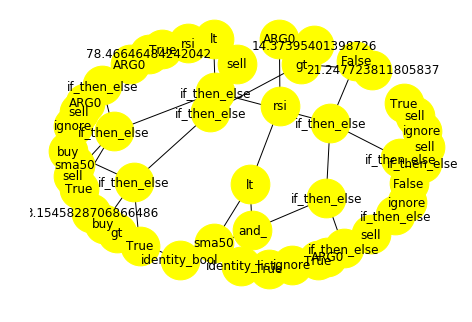

In [9]:
from chart_plotter import draw_tree
draw_tree(best)

In [12]:
print(performance_df.iloc[0].evaluation.get_report())

--

* Order execution log *

Start balance: cash = 1000 BTC, crypto = 0 
Start time: 2018-04-01 00:00:00
--
--
2018-04-09 13:00:00  	 OrderType.BUY    	 cash_balance ->      -1000.00 BTC 	 currency_balance -> 740627.993139 OMG 	 (1 OMG = 0.00134683 BTC ), slippage = 0.00
   signal: genetic_up strength=3 trend=1 horizon=None timestamp=2018-04-09 13:00:00 rsi_value=None
2018-04-13 04:00:00  	 OrderType.SELL   	 cash_balance ->       1354.48 BTC 	 currency_balance -> -740627.993139 OMG 	 (1 OMG = 0.00183341 BTC ), slippage = 0.00
   signal: genetic_down strength=3 trend=-1 horizon=None timestamp=2018-04-13 04:00:00 rsi_value=None
2018-04-13 06:00:00  	 OrderType.BUY    	 cash_balance ->      -1354.48 BTC 	 currency_balance -> 758977.547833 OMG 	 (1 OMG = 0.00178015 BTC ), slippage = 0.00
   signal: genetic_up strength=3 trend=1 horizon=None timestamp=2018-04-13 06:00:00 rsi_value=None
2018-04-24 20:00:00  	 OrderType.SELL   	 cash_balance ->       1502.79 BTC 	 currency_balance -> -758977

In [13]:
print(performance_df.iloc[0].evaluation.benchmark_backtest.get_report())

--

* Order execution log *

Start balance: cash = 1000 BTC, crypto = 0 
Start time: 2018-04-03 03:00:00
--
--
2018-04-03 03:00:00  	 OrderType.BUY    	 cash_balance ->      -1000.00 BTC 	 currency_balance -> 809652.519054 OMG 	 (1 OMG = 0.00123201 BTC ), slippage = 0.00
   signal: None
2018-06-01 00:00:00  	 OrderType.SELL   	 cash_balance ->       1142.62 BTC 	 currency_balance -> -809652.519054 OMG 	 (1 OMG = 0.00141478 BTC ), slippage = 0.00
   signal: None
End time: 2018-06-01 00:00:00

Summary
--
Number of trades: 2
End cash: 1142.62 BTC
End crypto: 0.000000 OMG
End price: 0.00141478
Total value invested: 1000 BTC
Total value after investment: 1142.62 BTC (+14.26%)
Profit: 142.62 BTC
Total value invested: 7165034.75 USDT (conversion on 2018-04-03 03:00:00)
Total value after investment: 8552484.43 USDT (+19.36%) (conversion on 2018-06-01 00:00:00)
Profit: 1387449.69 USDT

Additional stats:
  Max drawdown: -0.4012452438602555
  Max drawdown duration: 2847060.0
  Sharpe ratio: 0.216